<a href="https://colab.research.google.com/github/ibribr/ML/blob/master/olivetti_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.olivetti_faces import fetch_olivetti_faces

Data shape: (400, 4096)
Label shape: (400,)


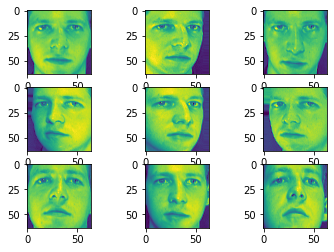

In [13]:
# Fetch data and have a look
faces = fetch_olivetti_faces()
x, y = faces['data'], faces['target']
print(f'Data shape: {x.shape}')
print(f'Label shape: {y.shape}')
# (400, 4096)
# (400,)

# create a grid of 3x3 images
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(x[i].reshape(64, 64))

# show the plot
plt.show()

# divide data into training, validation and testing (shuffle)

# use PCA for diensionality reduction - reconstruct images using a subset of features

# use autoencoder - reconstruct using a compressed representation (code)

# unsupervised algorithm

# supervised algorithm

# confusion matrix

#cross-validation  - SGD, BGD and MBGD

